### Overview

This jupyter notebook shows how to use TensorFlow to compute the linear (multiclass) SVM.
The result is verified by comparing to a CVXPY implementation of the linear SVM.

In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow as tf

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import tf_multiclass.losses as losses
import tf_multiclass.utils as utils
import tf_multiclass.metrics as metrics
from tf_multiclass.utils import to_t_categorical

from wwsvm import WWSVM

### Load the Iris dataset

In [3]:
X,y_orig = load_iris(return_X_y=True)
num_classes = len(np.unique(y_orig))
y = to_t_categorical(y_orig) # convert the digital labels to trimmed categorical labels
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [4]:
print("# features:", X.shape[1])
print("# classes:", num_classes)

# features: 4
# classes: 3


### Train WW SVM on Iris using CVXPY

The `WWSVM` solver optimizes the objective
$$
\frac{1}{2} \|\mathbf{w}\|_F^2 + C \sum_{i=1}^n \sum_{j=1: j \ne y_i}^k\mathtt{hinge}\left( (w_{y_i} - w_{j})^\top x_i\right)
$$

where $\mathbf{w} = \begin{bmatrix} w_1&\dots& w_k\end{bmatrix} \in \mathbb{R}^{d\times k}$ and $\mathtt{hinge}(t) = \max\{1-t,0\}$ is the ordinary hinge function.

In [5]:
C = 2**-1
clf = WWSVM(C = C)
clf.fit(X,y_orig, method = 'cvxpy')
wwsvm_opt_exact = clf.dual_objective_exact
wwsvm_opt_exact

30.13102032056637

### Train WW SVM on Iris using TensorFlow

The following code optimizes the loss
$$
\gamma \|\mathbf{w} \|_F^2 + \frac{1}{\mathtt{batch\_size}}
\sum_{i\in B} \sum_{j=1: j \ne y_i}^k\mathtt{hinge}\left( (w_{y_i} - w_{j})^\top x_i\right).
$$

In [6]:
gamma = 1/(2*C*X.shape[0])
# batch_size = X.shape[0]
batch_size = 20

initializer = tf.keras.initializers.Zeros()

inputs = keras.Input(shape=(X.shape[1],), name="features_in")
scores = layers.Dense(num_classes,
                      activation = "linear",
                      kernel_regularizer=regularizers.l2(gamma),
                      kernel_initializer=initializer,
                      use_bias=False)(inputs)
outputs = tf.expand_dims(scores[:,-1],axis=-1) - scores[:,:-1]

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=1e-1)
model.compile(loss=losses.WWHinge(), optimizer=optimizer, metrics=[metrics.RMarginAccuracy()])

history = model.fit(X,y,epochs=400,batch_size=batch_size,verbose=0)

In [7]:
wwsvm_opt_approx = C*X.shape[0]*history.history['loss'][-1]
wwsvm_opt_approx

30.445557832717896

### Plot results

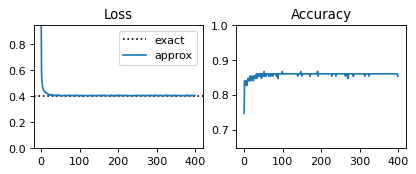

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6,2),dpi=80)

ax1.set_title('Loss')
ax1.axhline(wwsvm_opt_exact/(C*X.shape[0]),color="k",linestyle=":")
ax1.plot(history.history['loss'])
ax1.set_ylim((0,max(history.history['loss'])))
ax1.legend(['exact','approx'])

ax2.plot(history.history['accuracy'])
ax2.set_title('Accuracy')
ax2.set_ylim((min(history.history['accuracy'])-0.1,1))

plt.show()

In [9]:
print("Final (training) accuracy:",round(100*history.history['accuracy'][-1],2))

Final (training) accuracy: 85.33
